In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05a
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- multi-class

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20000 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg'

plt.rcParams.update(params)

## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;color:blue;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [4]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

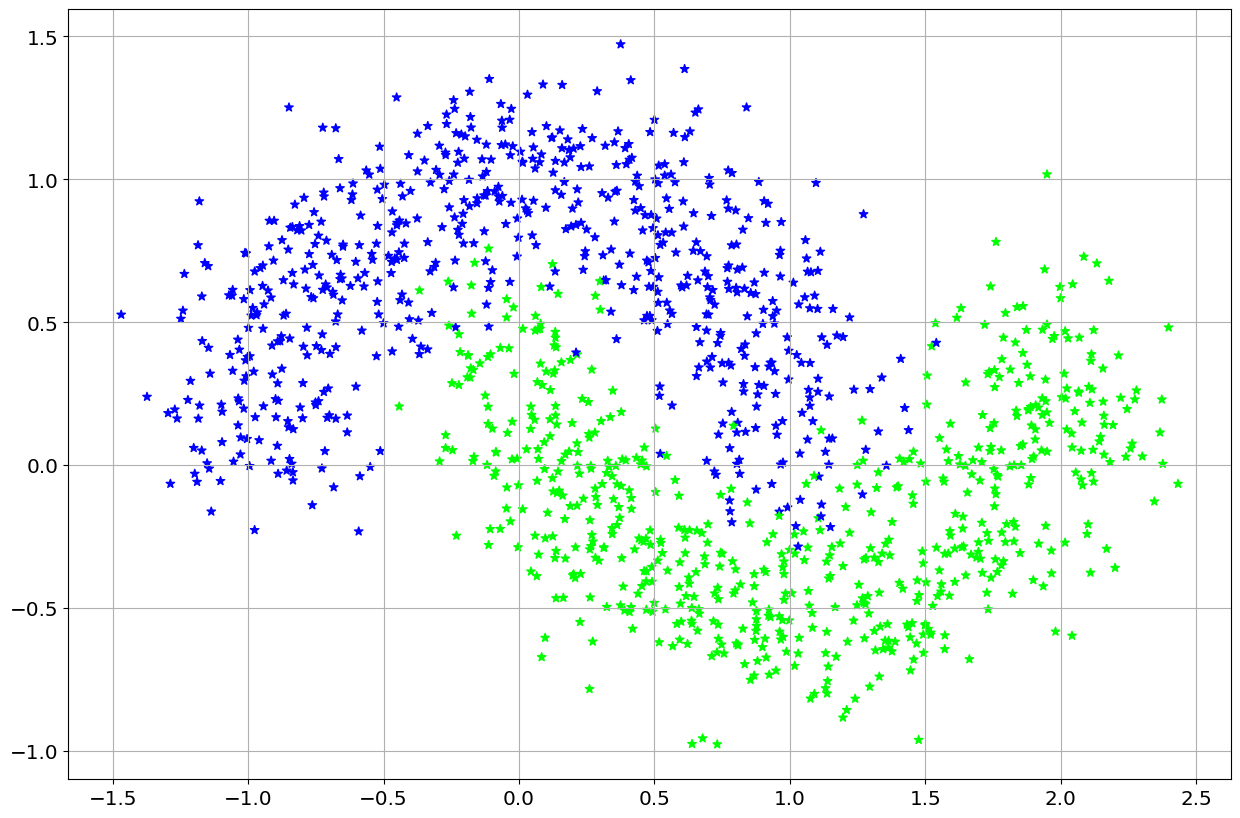

In [5]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP)

plt.grid()

In [6]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Args:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    

    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])

    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], 
                c=np.argmax(y, axis=1), ### for multiclass data
                cmap=CMAP, 
                edgecolors='black')

In [7]:
################################
### Make it multiclass data
################################

y = pd.get_dummies(y).values
y

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [8]:
y.shape

(1280, 2)

In [9]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src='images/dnn_nb_s05_fig1.png' width = '500' alt = 'Session 5 Figure 1'/>

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

<img src='images/dnn_nb_s05_fig2.png' width = '500' alt = 'Session 5 fig 2'/>

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


In [10]:
def fn_softmax(z):
    '''
        Args:
           z : array, Aggregated values 
       Return:
           probs. of each class
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc, axis = 1, keepdims= True)    

In [11]:
sm = fn_softmax(np.asarray([[8, 5, 0]]))
print (sm, '\nTotal of all values', sm.sum())

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]] 
Total of all values 0.9999999999999999


In [12]:
sm = fn_softmax(np.asarray([[-10, 0., 10]]))
print (sm, '\nTotal of all values', sm.sum())

[[2.06106005e-09 4.53978686e-05 9.99954600e-01]] 
Total of all values 0.9999999999999999


### Other Activation Function
Keep tanh Function for hidden layer

In [13]:
def fn_activ(x):

    return np.tanh(x)

def fn_activ_prime(x):

    return 1.0 - np.tanh(x)**2

## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [14]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    
    # extract weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = X.dot(W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = a1.dot(W2) + b2
    
    ####-----------------------
    ### Changes for multi class
    ####-----------------------    
    # sigmoid  activation
    a2 = fn_softmax(z2)


    # Calculating the loss
    data_loss = -(y * np.log(a2) + (1 - y) * np.log(1 - a2)).sum() 

    return 1./num_examples * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation.

In [15]:
# Helper function to predict an output (0 or 1)

def predict(model, X):
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = X.dot(W1) + b1
    
    a1 = fn_activ(z1)
    
    z2 = a1.dot(W2) + b2
    
    ####-----------------------
    ### Changes for multi class
    ####-----------------------    
    
    # Softmax Activation
    a2 = fn_softmax(z2)
    
    return np.argmax(a2, axis =1) # pick with one with highest probabilities

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Prepare Model:

In [16]:
def build_model(nn_hdim, X, y, 
                epochs = EPOCHS, 
                alpha = ALPHA,
                print_loss=False):
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Training features to train
        y : Trainig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    # Bias
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0
    loss = []
    epoch = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1
        
        # Activation function for layer 1
        a1 = fn_activ(z1)  
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        
        ####-----------------------
        ### Changes for multi class
        ####-----------------------
        a2 = fn_softmax(z2)
        #a2 = fn_sigmoid(z2)

        #######################
        #   Back propagation  #
        #######################
        # Layer 2
        dz2 = a2-y

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) # db2 is sum along axis 0
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
            
        dz1 = dz2.dot(W2.T) * fn_activ_prime(z1)  #derivative of Activation Function
        #                                        '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
        
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/num_examples
        b1 += -alpha * db1/num_examples
        W2 += -alpha * dW2/num_examples
        b2 += -alpha * db2/num_examples
        
        #  Model as a Dict object to be return.
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
        
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, curr_loss))
            
    curr_loss = calculate_loss(model, X, y)
    loss.append(curr_loss)
    epoch.append(i)
    print("Loss after iteration %i: %f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [17]:
num_examples = len(X_train) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# lists to facilitate plotting 
loss_hist = {}

In [18]:
#y_train = y_train.reshape(-1,1)
y_train.shape

(1024, 2)

In [19]:
# Build a model with a 4-dimensional hidden layer
model = build_model(4, X_train, y_train,
                    epochs = EPOCHS, 
                    alpha = ALPHA, 
                    print_loss=True)

Loss after iteration 0: 0.000000
Loss after iteration 1000: 0.571842
Loss after iteration 2000: 0.346703
Loss after iteration 3000: 0.200554
Loss after iteration 4000: 0.164242
Loss after iteration 5000: 0.154308
Loss after iteration 6000: 0.150697
Loss after iteration 7000: 0.149075
Loss after iteration 8000: 0.148206
Loss after iteration 9000: 0.147664
Loss after iteration 10000: 0.147280
Loss after iteration 11000: 0.146981
Loss after iteration 12000: 0.146731
Loss after iteration 13000: 0.146514
Loss after iteration 14000: 0.146320
Loss after iteration 15000: 0.146144
Loss after iteration 16000: 0.145983
Loss after iteration 17000: 0.145835
Loss after iteration 18000: 0.145697
Loss after iteration 19000: 0.145569
Loss after iteration 19999: 0.145449


In [20]:
model

{'W1': array([[ 2.50201047,  0.72754418,  3.07114092, -2.78833211],
        [-1.32822139,  0.63876031,  1.83326025,  1.13370555]]),
 'b1': array([[-3.13856208, -0.3847706 , -1.86868415, -1.2735382 ]]),
 'W2': array([[-3.77192105,  4.03218335],
        [ 0.11342016,  0.23004686],
        [ 4.19470774, -3.38981074],
        [ 3.83413637, -3.44343177]]),
 'b2': array([[-0.21793782,  0.21793782]])}

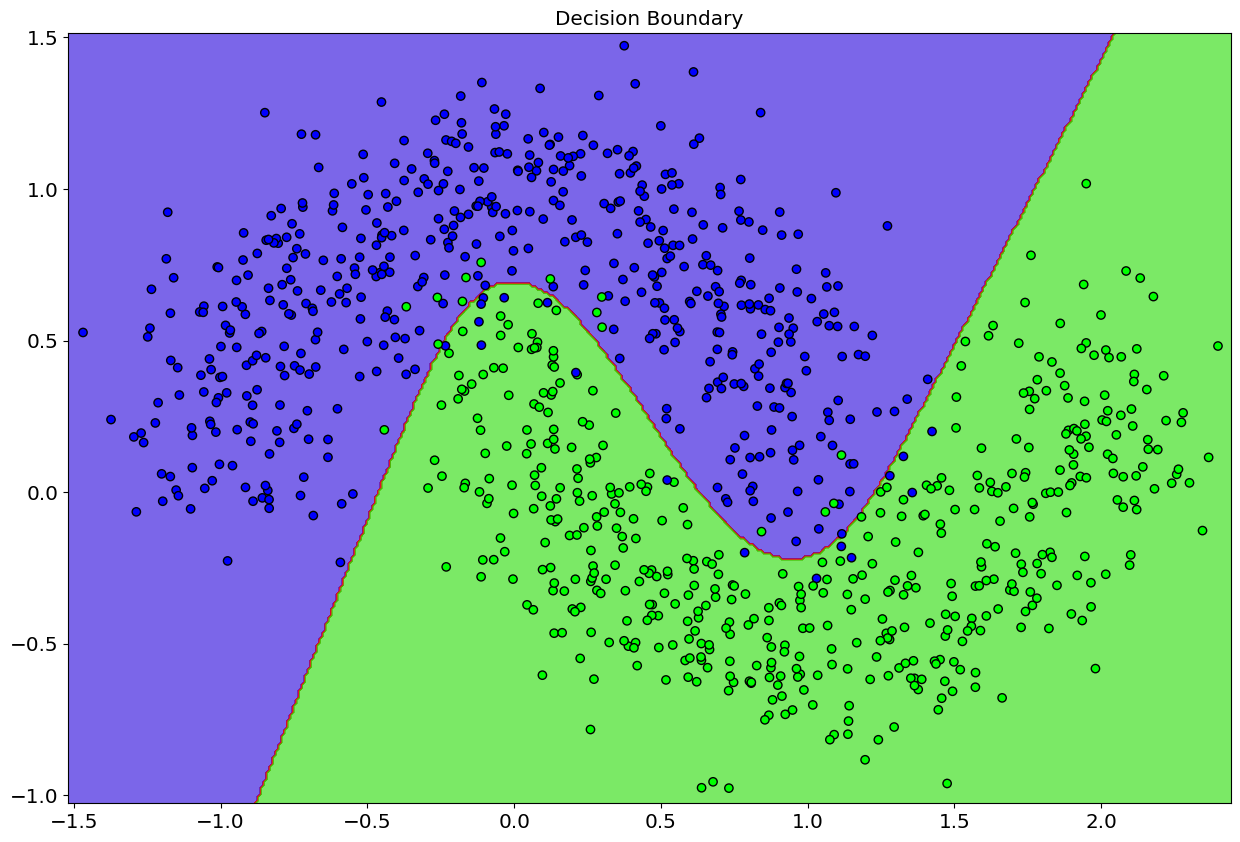

In [21]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

plt.title("Decision Boundary");

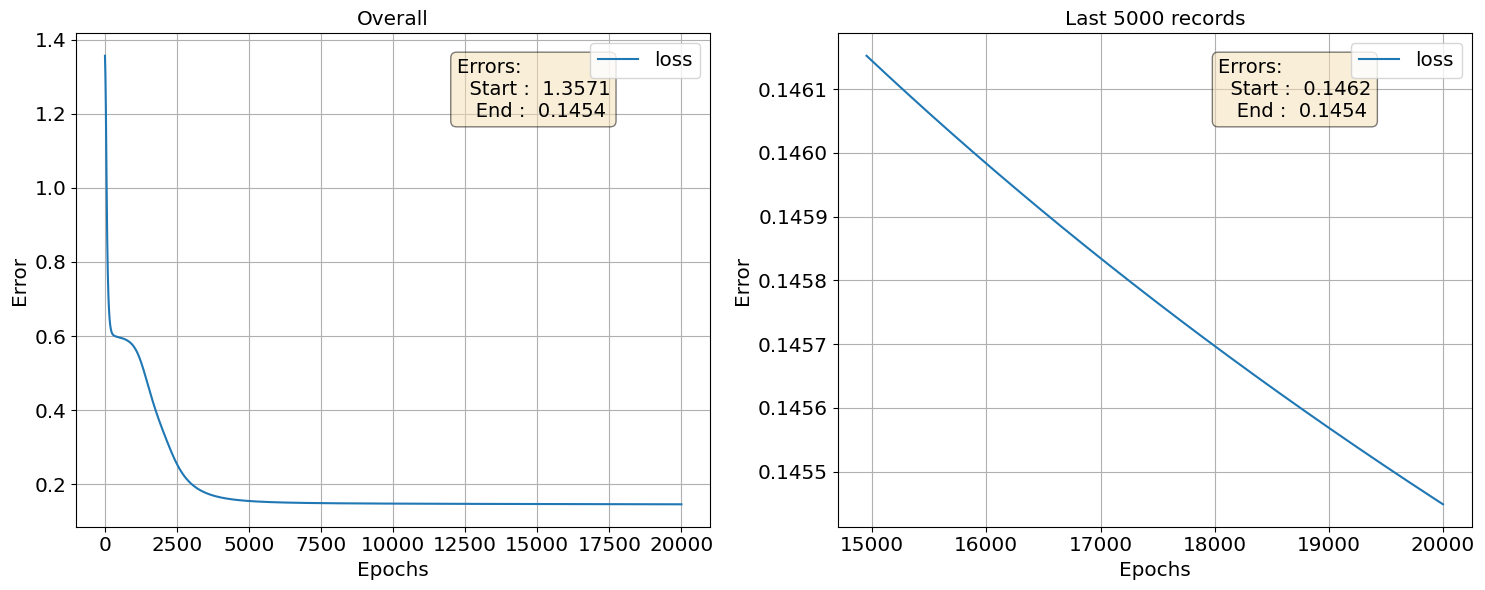

In [22]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 5000

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

### Would contest that we should have used higher epochs as loss is still coming down? How many epochs are sufficient?

In [23]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [24]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

Accuracy score on Train Data : 0.96875


In [25]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       522
           1       0.97      0.97      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



In [26]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.9609375


In [27]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.96      0.96      0.96       138

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



In [28]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[113,   5],
       [  5, 133]])

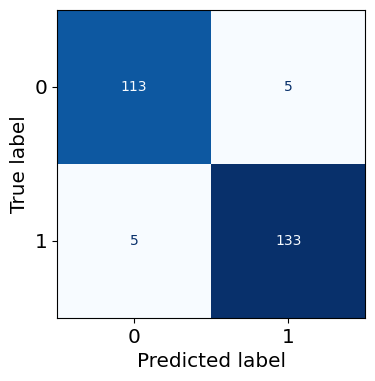

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();